In [1]:
from pathlib import Path
import webbrowser

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

from evolution.evaluation.evaluator import EnROADSEvaluator
from experiments.experiment_utils import NNExperimenter, DirectExperimenter
from enroadspy import load_input_specs, id_to_name
from enroadspy.generate_url import actions_to_url

In [2]:
results_dir = Path("results/action-simple-nocarbon")
with open(results_dir / "config.yml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

gens = len(list(results_dir.glob("[0-9]*.csv")))-1
context = config["context"]
actions = config["actions"]
outcomes = config["outcomes"]
outcome_keys = list(outcomes.keys())
n_elites = config["evolution_params"]["n_elites"]
print(gens, outcomes, len(actions), len(context))

399 {'Actions taken': True, 'Simple action magnitude': True, 'Temperature change from 1850': True} 15 0


In [3]:
input_specs = load_input_specs()

evaluator = EnROADSEvaluator(context, actions, outcomes, n_jobs=1, batch_size=config["batch_size"], device=config["device"])
if len(context) > 0:
    experimenter = NNExperimenter(results_dir)
else:
    experimenter = DirectExperimenter(results_dir)

make: `enroads' is up to date.
make: `enroads' is up to date.


In [4]:
def filter_actions_dict(actions_dict: dict):
    input_specs = load_input_specs()
    filtered = {}
    for action in actions_dict:
        default = input_specs[input_specs["varId"] == action]["defaultValue"].values[0]
        if actions_dict[action] != default:
            filtered[action] = actions_dict[action]
    return filtered

{'Source subsidy delivered oil boe': 1.0, 'Annual improvement to energy efficiency of new capital stationary': 1.0, 'Target change other GHGs leakage and waste': 0.88, 'Land CDR percent of reference': 0.795, 'Target change in other GHGs for ag': 0.72, 'Source subsidy delivered coal tce': 0.535, 'Annual improvement to energy efficiency of new capital transport': 0.45, 'Tech CDR percent of reference': 0.415, 'Deforestation slider setting': 0.39, 'Source subsidy delivered gas MCF': 0.31, 'Electric carrier subsidy with required comp assets': 0.285, 'Source subsidy renewables kWh': 0.245, 'Source subsidy nuclear kWh': 0.135, 'Source subsidy delivered bio boe': 0.075, 'Electric carrier subsidy stationary': 0.0}


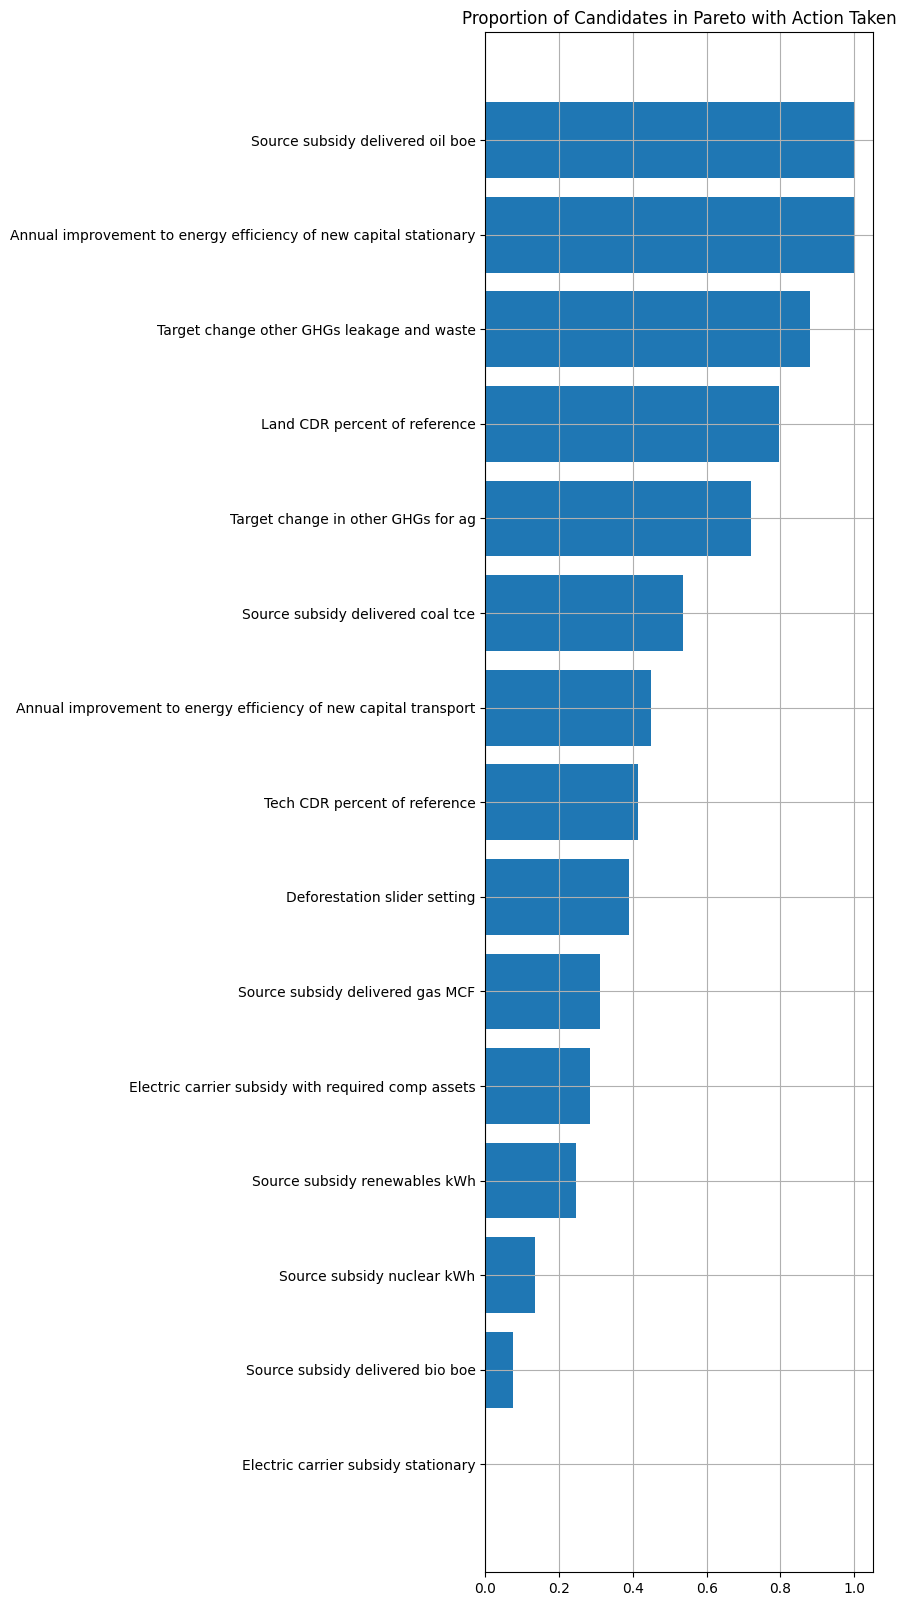

In [20]:
def plot_actions_taken(gen: int, magnitude=False):
    gen_df = pd.read_csv(results_dir / f"{gen}.csv")
    gen_df = gen_df[gen_df["rank"] == 1]
    pareto_len = len(gen_df)
    actions_count = {action: 0 for action in actions}
    for cand_id in gen_df["cand_id"]:
        [context_actions_dict], _, _ = experimenter.get_candidate_results(cand_id)
        for action in context_actions_dict:
            row = input_specs[input_specs["varId"] == action].iloc[0]
            default_value = row["defaultValue"]
            if action not in context and context_actions_dict[action] != default_value:
                if not magnitude:
                    actions_count[action] += 1
                else:
                    min_value = row["minValue"] if row["kind"] == "slider" else row["offValue"]
                    max_value = row["maxValue"] if row["kind"] == "slider" else row["onValue"]
                    if min_value == max_value:
                        continue
                    norm = (context_actions_dict[action] - min_value) / (max_value - min_value)
                    default_norm = (default_value - min_value) / (max_value - min_value)
                    actions_count[action] += abs(norm - default_norm)

    # Switch to nice name, normalize values
    actions_count = {action: count / pareto_len for action, count in actions_count.items()}
    actions_count = dict(sorted(actions_count.items(), key=lambda item: item[1], reverse=True))
    pretty_actions_count = {id_to_name(action, input_specs): count for action, count in actions_count.items()}

    print(pretty_actions_count)
    fig, ax = plt.subplots(figsize=(5, 20))
    ax.barh(pretty_actions_count.keys(), pretty_actions_count.values())
    ax.set_title("Proportion of Candidates in Pareto with Action Taken")
    ax.grid()
    ax.invert_yaxis()
    plt.show()

    return actions_count

actions_count = plot_actions_taken(gens, magnitude=False)

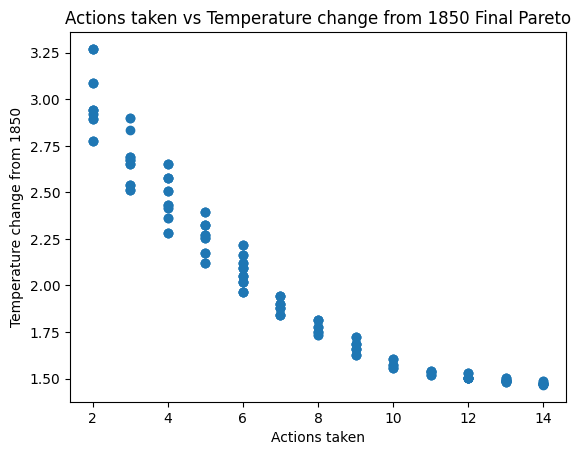

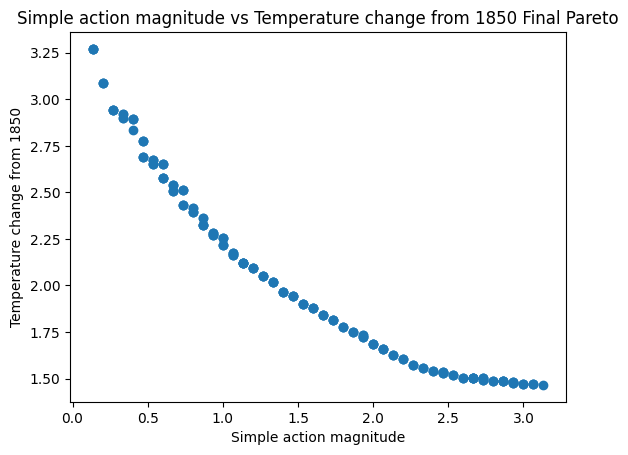

In [6]:
def plot_pareto(outcome1, outcome2, gen, colored_ids=[]):

    gen_df = pd.read_csv(results_dir / f"{gen}.csv")
    gen_df = gen_df[gen_df["rank"] == 1]
    gen_df["color"] = gen

    plt.scatter(gen_df[outcome1], gen_df[outcome2])

    colors = ["pink", "lightgreen"]
    for colored_id, color in zip(colored_ids, colors):
        colored_df = gen_df[gen_df["cand_id"] == colored_id]
        plt.scatter(colored_df[outcome1], colored_df[outcome2], color=color)

    title = f"{outcome1} vs {outcome2} Final Pareto"
    plt.title(title)
    plt.ylabel(outcome2)
    plt.xlabel(outcome1)
    plt.show()

plot_pareto(outcome_keys[0], outcome_keys[2], gens)
plot_pareto(outcome_keys[1], outcome_keys[2], gens)

In [7]:
def find_special(special_outcomes: list[str]):
    """
    Find the special candidates in the Pareto.
    Special means the largest difference in temperature and smallest mean difference in the normalized other outcomes.
    """
    pareto_df = pd.read_csv(results_dir / f"{gens}.csv")
    pareto_df = pareto_df[pareto_df["rank"] == 1]

    special_outcomes = ["Temperature change from 1850"] + special_outcomes
    ascending = [False] + [True] * (len(special_outcomes) - 1)

    pareto_df = pareto_df.sort_values(by=special_outcomes, ascending=ascending)

    print(pareto_df.head())

    diffs = pareto_df[special_outcomes].diff().abs().dropna()
    diffs = diffs.sort_values(by=special_outcomes, ascending=ascending)

    print(diffs.head())

    combined = pd.concat([diffs, pareto_df["cand_id"]], ignore_index=False, axis=1)
    special_id = combined.iloc[0]["cand_id"]

    pareto_row_position = pareto_df.index.get_loc(pareto_df[pareto_df['cand_id'] == special_id].index[0])
    special_rows = pareto_df.iloc[pareto_row_position-1:pareto_row_position+1]
    return special_rows["cand_id"].tolist()

print(outcome_keys)
special = find_special([outcome_keys[0], outcome_keys[1]])
print(special)

['Actions taken', 'Simple action magnitude', 'Temperature change from 1850']
     cand_id                 parents  rank  distance  \
1    201_135    ['82_50', '200_165']     1       inf   
4    390_116   ['377_95', '201_135']     1       inf   
128   377_95    ['374_19', '331_46']     1  0.000000   
185  391_153  ['387_189', '390_116']     1  0.000000   
13   399_165    ['398_13', '393_93']     1  0.122409   

     Temperature change from 1850  Actions taken  Simple action magnitude  
1                         3.27069            2.0                 0.133333  
4                         3.27069            2.0                 0.133333  
128                       3.27069            2.0                 0.133333  
185                       3.27069            2.0                 0.133333  
13                        3.08988            2.0                 0.200000  
    Temperature change from 1850  Actions taken  Simple action magnitude
13                       0.18081            0.0          

     cand_id  Temperature change from 1850  Simple action magnitude  \
1    201_135                       3.27069                 0.133333   
4    390_116                       3.27069                 0.133333   
128   377_95                       3.27069                 0.133333   
185  391_153                       3.27069                 0.133333   
13   399_165                       3.08988                 0.200000   

     Actions taken  
1              2.0  
4              2.0  
128            2.0  
185            2.0  
13             2.0  


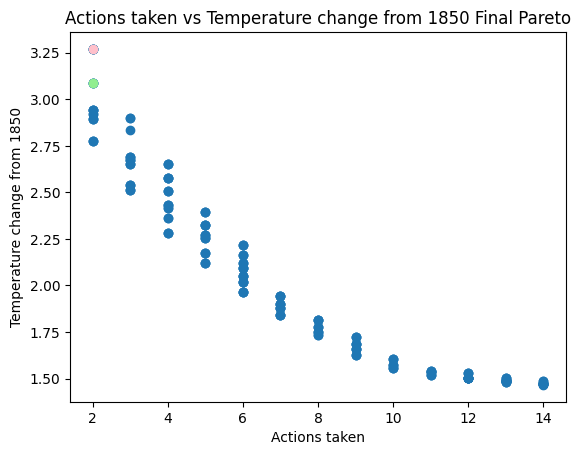

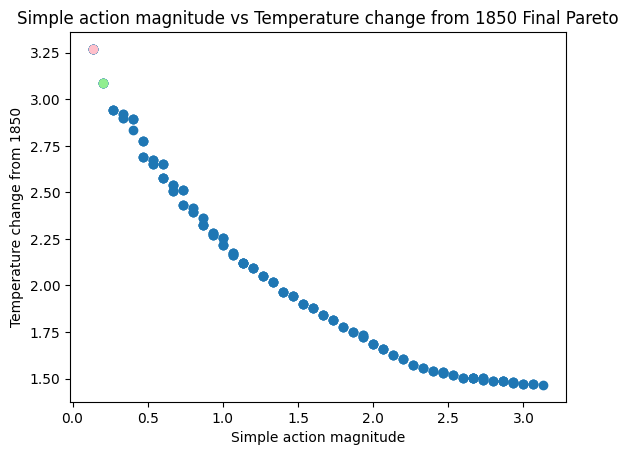

In [8]:
pareto_df = pd.read_csv(results_dir / f"{gens}.csv")
pareto_df = pareto_df[pareto_df["rank"] == 1]
pareto_df = pareto_df.sort_values(by=[outcome_keys[2], outcome_keys[1], outcome_keys[0]], ascending=False)

print(pareto_df[["cand_id", outcome_keys[2], outcome_keys[1], outcome_keys[0]]].head())
# 57_162, 63_147
# special = ["351_138", "397_26"]
plot_pareto(outcome_keys[0], outcome_keys[2], gens, special)
plot_pareto(outcome_keys[1], outcome_keys[2], gens, special)

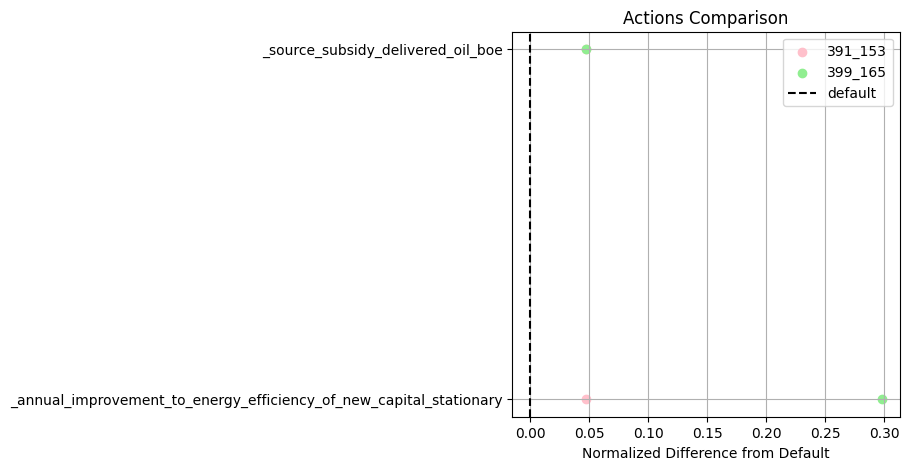

In [9]:
def compare_actions(cand_1, cand_2):
    [ca_1], _, _ = experimenter.get_candidate_results(cand_1)
    [ca_2], _, _ = experimenter.get_candidate_results(cand_2)

    total_actions = list(set(ca_1.keys()).union(set(ca_2.keys())))

    all_actions = []
    norm1s = []
    norm2s = []
    defaults = []
    mins = []
    maxes = []

    for action in total_actions:
        row = input_specs[input_specs["varId"] == action].iloc[0]
        default_value = row["defaultValue"]
        min_value = row["minValue"] if row["kind"] == "slider" else row["offValue"]
        max_value = row["maxValue"] if row["kind"] == "slider" else row["onValue"]

        if ca_1[action] == default_value and ca_2[action] == default_value:
            continue

        if min_value == max_value:
            norm_1 = 1
            norm_2 = 1
            norm_default = 1

        else:
            norm_default = (default_value - min_value) / (max_value - min_value)
            norm_1 = (ca_1[action] - min_value) / (max_value - min_value)
            norm_2 = (ca_2[action] - min_value) / (max_value - min_value)

            diff_1 = norm_1 - norm_default
            diff_2 = norm_2 - norm_default

        norm1s.append(diff_1)
        norm2s.append(diff_2)
        defaults.append(norm_default)
        mins.append(min_value)
        maxes.append(max_value)
        all_actions.append(action)

    df = pd.DataFrame({"action": all_actions,
                       "norm1": norm1s,
                       "norm2": norm2s,
                       "default": defaults,
                       "min": mins,
                       "max": maxes})
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(df["norm1"], range(len(df)), label=cand_1, color="pink")
    ax.scatter(df["norm2"], range(len(df)), label=cand_2, color="lightgreen")
    ax.axvline(x=0, color="black", linestyle="--", label="default")

    ax.set_xlabel("Normalized Difference from Default")
    ax.set_yticks(range(len(df)), df["action"])
    ax.set_title("Actions Comparison")
    ax.grid()
    ax.legend()

    plt.show()

compare_actions(*special)

In [10]:
def print_actions_dict(cand_id):
    [context_actions_dict], [outcomes_df], _ = experimenter.get_candidate_results(cand_id)
    true_ca_dict = {}
    for action in context_actions_dict:
        default_value = input_specs[input_specs["varId"] == action]["defaultValue"].values[0]
        if context_actions_dict[action] != default_value:
            true_ca_dict[action] = context_actions_dict[action]
    print(true_ca_dict)

In [18]:
print_actions_dict("1_2")

{'_source_subsidy_delivered_oil_boe': 9.5367431640625e-07, '_annual_improvement_to_energy_efficiency_of_new_capital_stationary': 1.2000000476837158}


In [11]:
for cand_id in special:
    print_actions_dict(cand_id)

{'_source_subsidy_delivered_oil_boe': 4.774528503417969, '_annual_improvement_to_energy_efficiency_of_new_capital_stationary': 1.4863612651824951}
{'_source_subsidy_delivered_oil_boe': 4.774528503417969, '_annual_improvement_to_energy_efficiency_of_new_capital_stationary': 2.9889848232269287}


-15.0 100.0


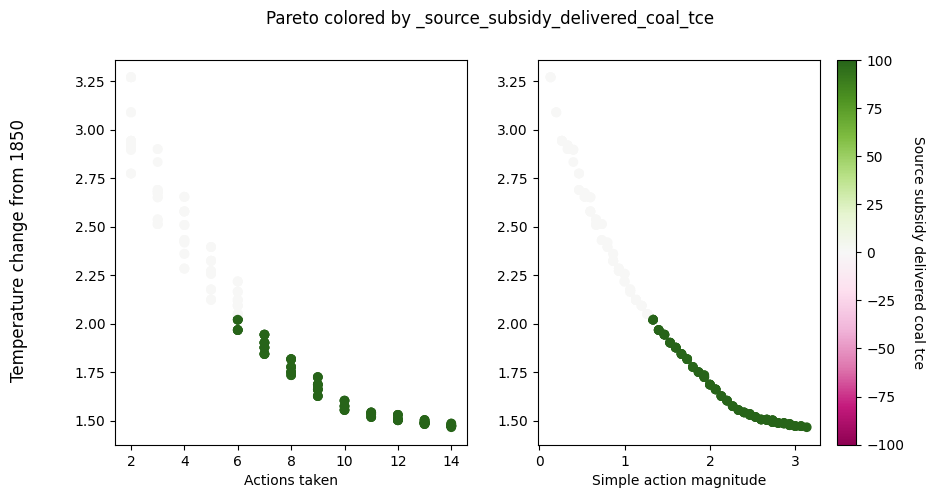

-15.0 85.0


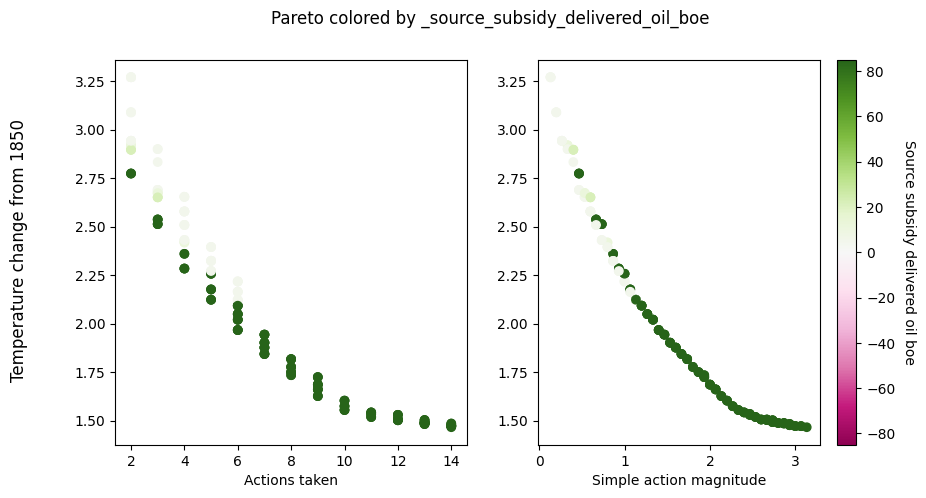

-0.7 5.0


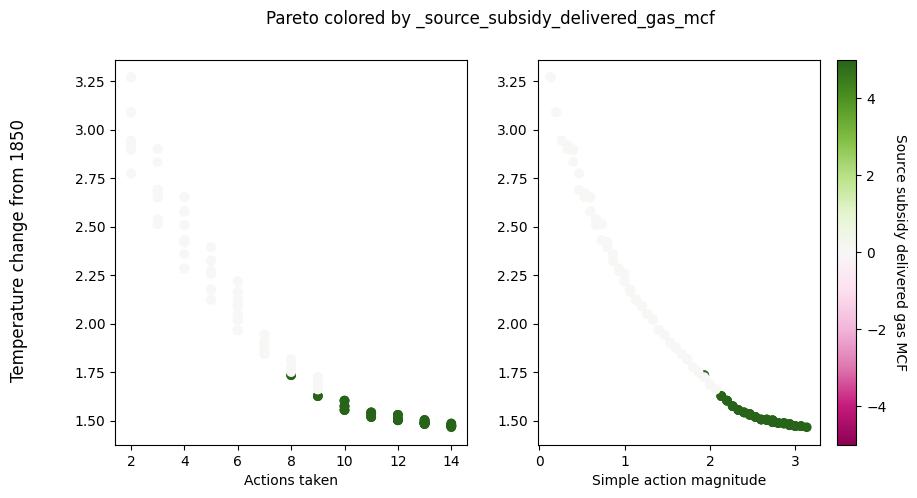

-0.05 0.02


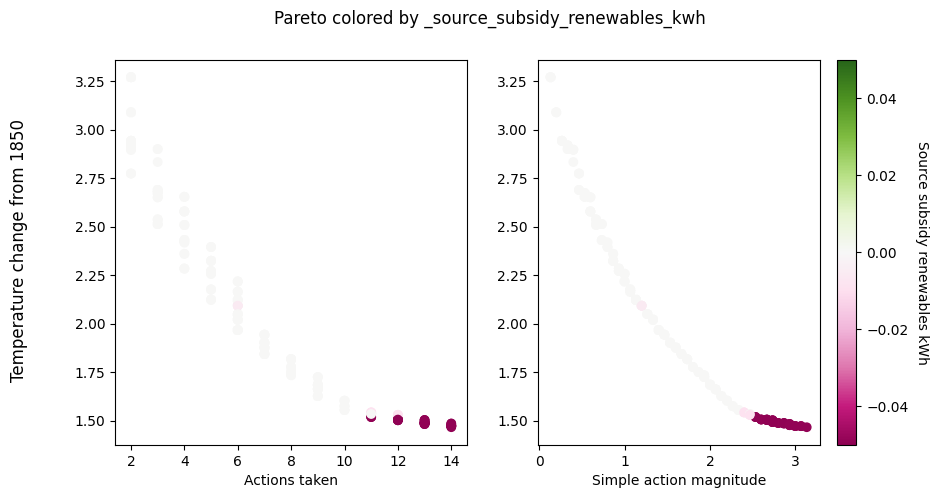

-25.0 25.0


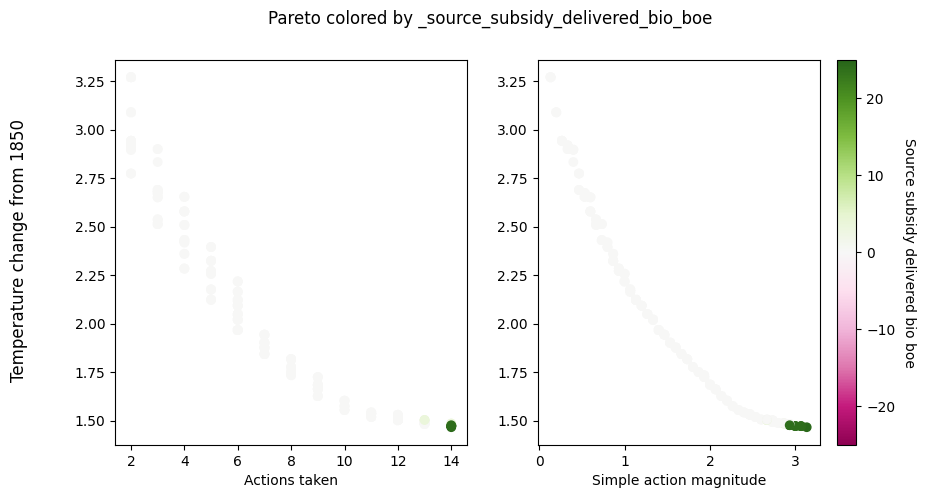

-0.07 0.07


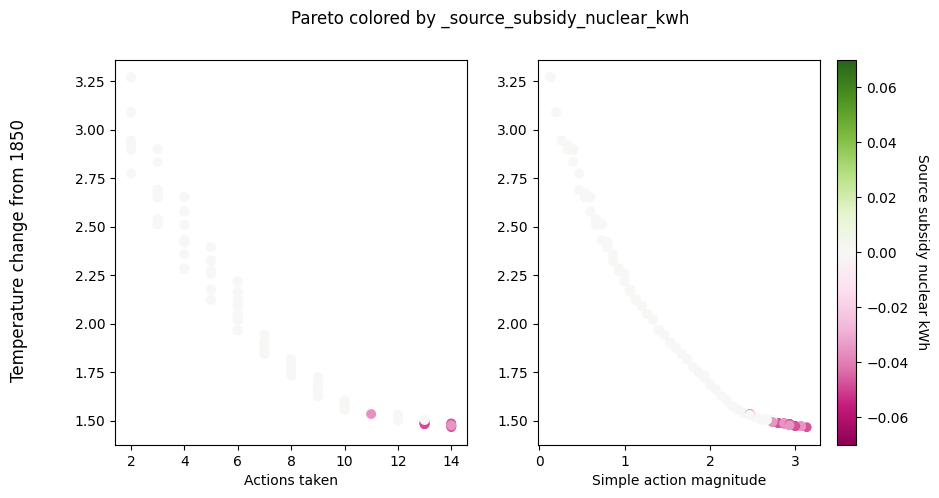

-1.0 5.0


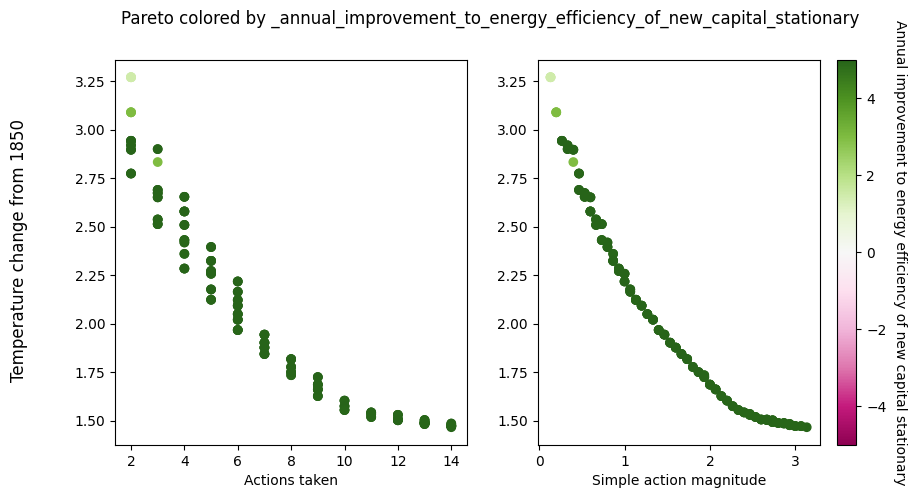

-1.0 5.0


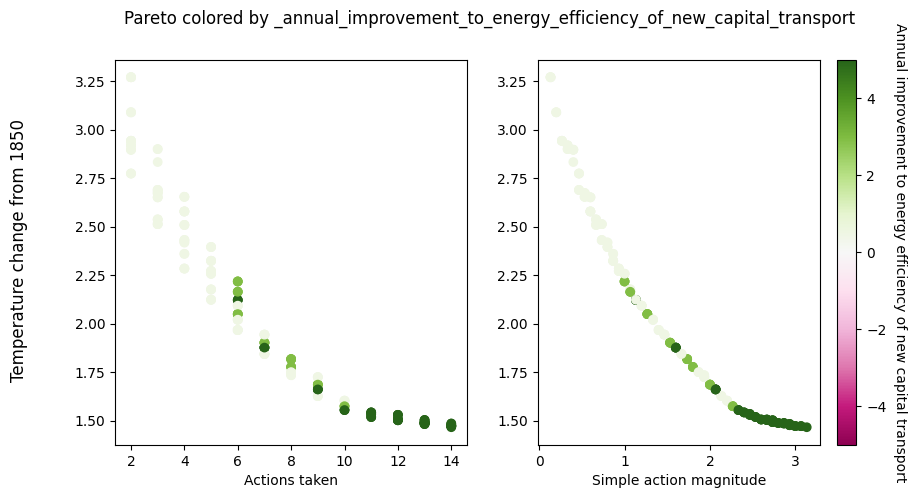

0.0 50.0


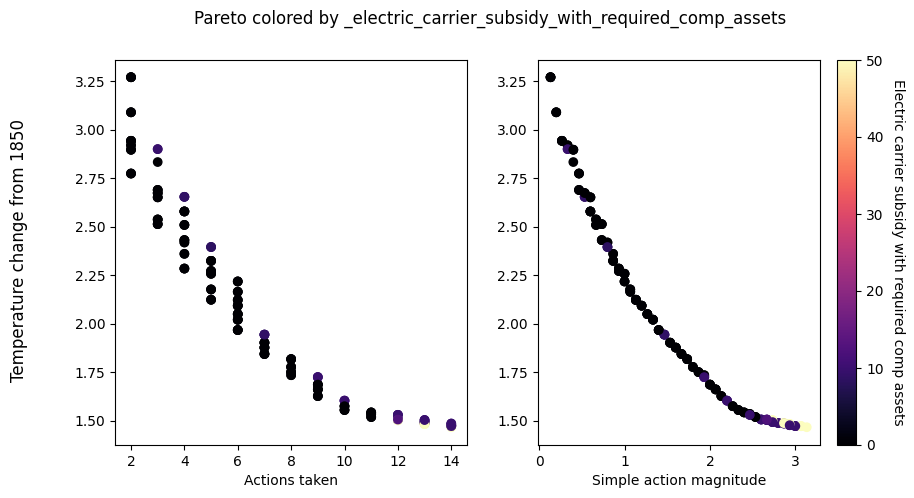

0.0 50.0


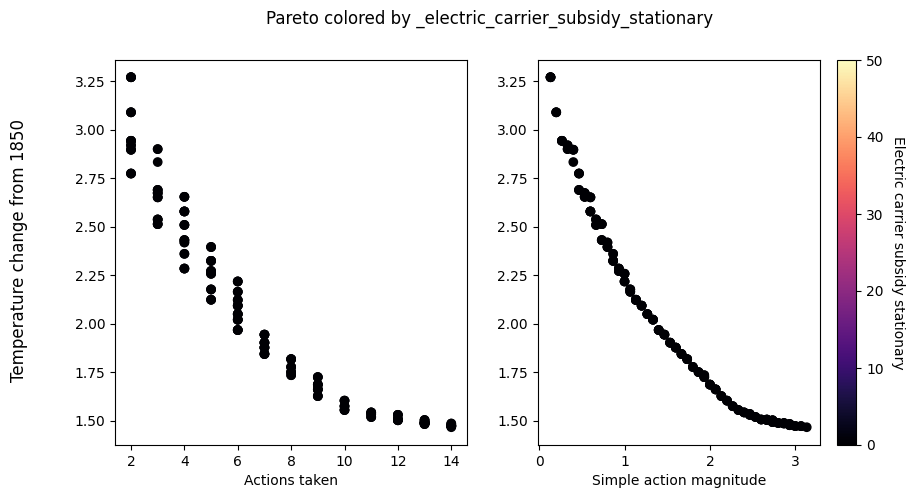

-10.0 100.0


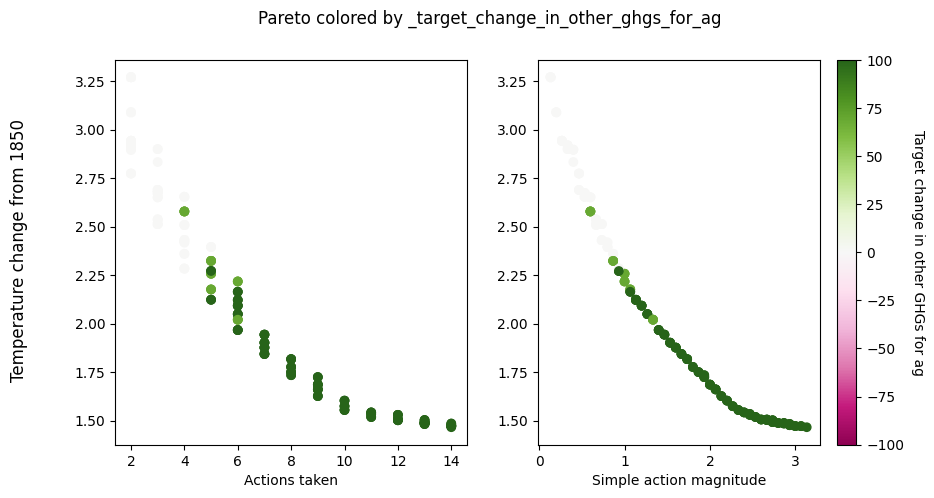

0.0 100.0


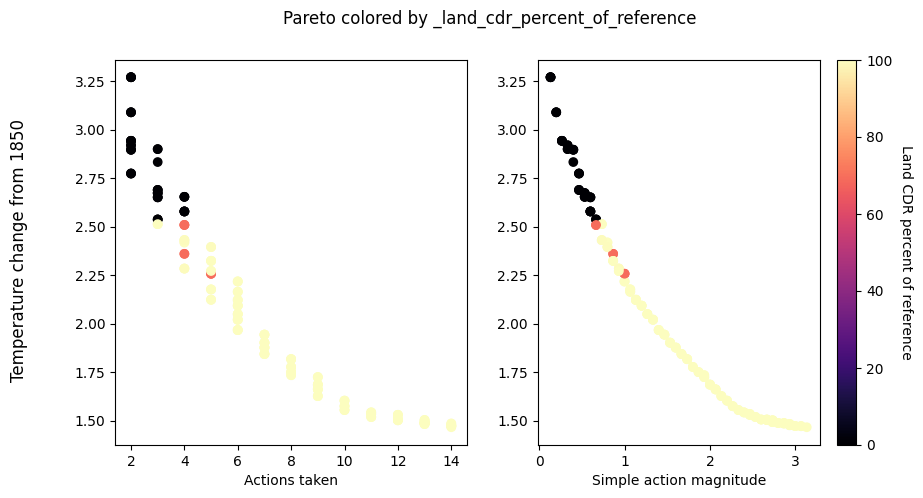

-10.0 100.0


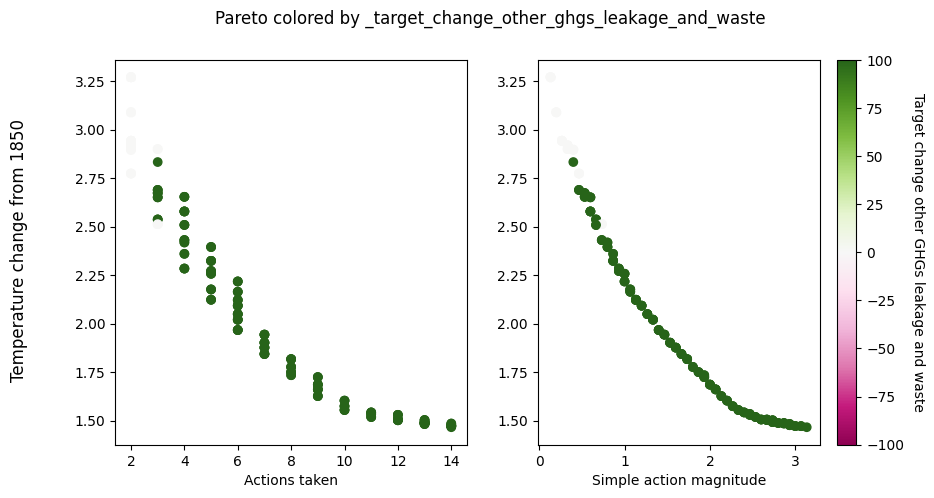

-10.0 1.0


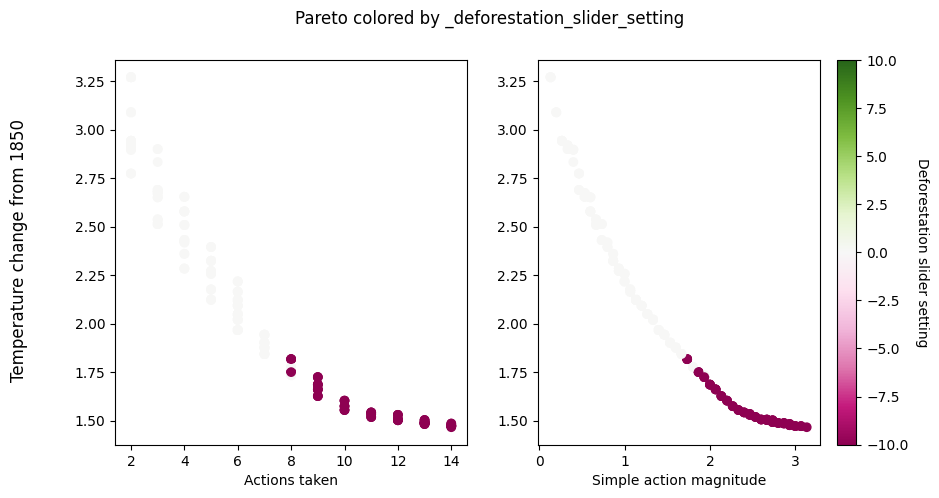

0.0 100.0


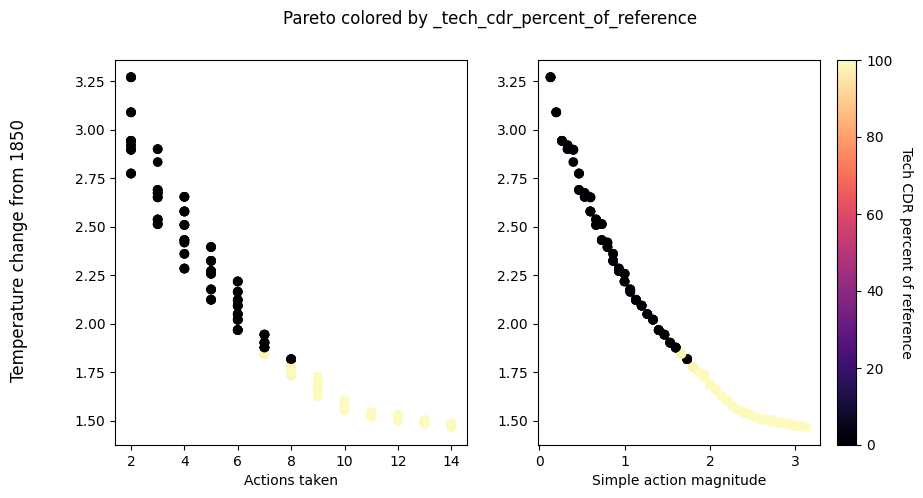

Bad pipe message: %s [b' #\x9f\x1c\xbe\xdd{\xda\xcf\xe1\x90\x14\xb0\xbal\xaa\xe1\xb6\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00', b'=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c']
Bad pipe message: %s [b'\xf2\xb8G\xcb\x80\xbd!\xfb\xe5\x1f\x9c\x15\xbd\x10?x\xdaS\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00', b'A\x00B\x00C\x00D\x00E\x00

In [ ]:
def color_pareto_by_action(action: str, x_outcomes: list[str], y_outcome: str):
    pareto_df = pd.read_csv(results_dir / f"{gens}.csv")
    pareto_df = pareto_df[pareto_df["rank"] == 1]

    action_vals = []
    for cand_id in pareto_df["cand_id"]:
        [context_actions_dict], _, _ = experimenter.get_candidate_results(cand_id)
        action_vals.append(context_actions_dict[action])
    
    pareto_df["action"] = action_vals

    fig, axes = plt.subplots(1, len(x_outcomes), figsize=(10, 5))
    axes = axes.flatten()

    input_specs = load_input_specs()
    min_val = input_specs[input_specs["varId"] == action]["minValue"].values[0]
    max_val = input_specs[input_specs["varId"] == action]["maxValue"].values[0]
    print(min_val, max_val)

    if min_val < 0 and max_val > 0:
        cmap_params = {"cmap": "PiYG", "vmin": min(min_val, -max_val), "vmax": max(-min_val, max_val)}
    elif min_val < 0 and max_val <= 0:
        cmap_params = {"cmap": "magma_r", "vmin": min_val, "vmax": max_val}
    else:
        cmap_params = {"cmap": "magma", "vmin": min_val, "vmax": max_val}

    for ax, x_outcome in zip(axes, x_outcomes):
        scatter = ax.scatter(pareto_df[x_outcome], pareto_df[y_outcome], c=pareto_df["action"], **cmap_params)
        ax.set_xlabel(x_outcome)
    
    fig.suptitle(f"Pareto colored by {action}")
    fig.supylabel(y_outcome)

    cbar = fig.colorbar(scatter)
    cbar.set_label(id_to_name(action, load_input_specs()), rotation=270, labelpad=15)
    plt.show()

# color_pareto_by_action("_carbon_tax_initial_target", [outcome_keys[0], outcome_keys[1]], outcome_keys[2])
for action in actions:
    color_pareto_by_action(action, [outcome_keys[0], outcome_keys[1]], outcome_keys[2])

In [13]:
from enroadspy.generate_url import generate_actions_dict
simple_dict = generate_actions_dict("https://en-roads.climateinteractive.org/scenario.html?v=25.4.0&p1=32&p7=33&p10=2&p16=-0.01&p23=10&p30=-0.04&p39=125&p47=0.2&p50=2.7&p373=10&p375=12&p60=46&p417=38&p61=42&p57=-5.1&p67=27")

print(list(simple_dict.keys()))

['_source_subsidy_delivered_coal_tce', '_source_subsidy_delivered_oil_boe', '_source_subsidy_delivered_gas_mcf', '_source_subsidy_renewables_kwh', '_source_subsidy_delivered_bio_boe', '_source_subsidy_nuclear_kwh', '_carbon_tax_initial_target', '_annual_improvement_to_energy_efficiency_of_new_capital_stationary', '_annual_improvement_to_energy_efficiency_of_new_capital_transport', '_electric_carrier_subsidy_with_required_comp_assets', '_electric_carrier_subsidy_stationary', '_target_change_in_other_ghgs_for_ag', '_land_cdr_percent_of_reference', '_target_change_other_ghgs_leakage_and_waste', '_deforestation_slider_setting', '_tech_cdr_percent_of_reference']


In [14]:
# [context_actions_dict], _, _ = experimenter.get_candidate_results(pareto_df.sort_values(outcome_keys[2])["cand_id"].values[0])
# print(filter_actions_dict(context_actions_dict))
# context_actions_dict = evaluator.decomplexify_actions_dict(context_actions_dict)
# url = actions_to_url(context_actions_dict)
# webbrowser.open(url)

In [15]:
color_pareto_by_action("_carbon_tax_final_target", outcome_keys[1], outcome_keys[2])

KeyError: '_carbon_tax_final_target'